## Authentication and enabling GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
# Tensorflow is already installed in Colab
# check if tensorflow is installed
import tensorflow as tf
print(tf.__version__) 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('you must enable GPU! Go to:')
  print('\nRuntime')
  print('\tChange runtime type')
  print('\t\tHardware Accelerator: GPU')

  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.0
Found GPU at: /device:GPU:0


## Loading Dataset

In [33]:
import os
import numpy as np
import os.path
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_SIZE = 4 
NUMBER_CLASSES = 30
PATIENCE = 10
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
EPOCH = 40



In [20]:
def build_pandas_dataframe(X,y):
  filepath = pd.Series(X, name='Filepath').astype(str)
  labels = pd.Series(y, name='Label')

  # Concatenate filepaths and labels
  df = pd.concat([filepath, labels], axis=1)

  # Shuffle the DataFrame and reset index
  #df = df.sample(frac=1).reset_index(drop = True) #This could be avoid because another shuffle will be done during ImgageDataGenerator.
  return df

In [26]:
from pathlib import Path
import os.path
filenames = os.listdir("cap")
#labels = [str(filepaths[i]).split("/")[-2] for i in range(len(filepaths))]
filenames.remove(".ipynb_checkpoints")
#filenames
labels = []
for f in filenames:
  labels.append(f[0].lower())


In [30]:


X = filenames
y = labels


#Generate train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)


def build_pandas_dataframe(X,y):
  filepath = pd.Series(X, name='Filepath').astype(str)
  labels = pd.Series(y, name='Label')

  # Concatenate filepaths and labels
  df = pd.concat([filepath, labels], axis=1)

  # Shuffle the DataFrame and reset index
  #df = df.sample(frac=1).reset_index(drop = True) #This could be avoid because another shuffle will be done during ImgageDataGenerator.
  return df

df_train = build_pandas_dataframe(X_train,y_train)
df_test = build_pandas_dataframe(X_test,y_test)


print(df_train)
print(df_test)

     Filepath Label
0      c5.png     c
1       x.png     x
2     c54.png     c
3      vd.png     v
4      kh.png     k
..        ...   ...
91  iiiii.png     i
92    u68.png     u
93     P0.png     p
94      p.png     p
95     6v.png     6

[96 rows x 2 columns]
    Filepath Label
0     ny.png     n
1      m.png     m
2     ww.png     w
3   6666.png     6
4      j.png     j
5    511.png     5
6     dd.png     d
7     x1.png     x
8     uu.png     u
9     kk.png     k
10    y6.png     y
11    9j.png     9
12    h5.png     h
13    po.png     p
14     e.png     e
15    61.png     6
16    12.png     1
17     g.png     g
18    i1.png     i
19    35.png     3
20     z.png     z
21    57.png     5
22    f1.png     f
23   2GG.png     2
24    77.png     7
25    21.png     2
26    PL.png     p
27    cs.png     c
28    q1.png     q
29    r1.png     r
30    lj.png     l
31    cc.png     c


In [31]:
df_train_group = df_train.groupby(["Label"])["Filepath"].count().reset_index(name="Count")
df_test_group = df_test.groupby(["Label"])["Filepath"].count().reset_index(name="Count")
#df2['Count'].astype(int)

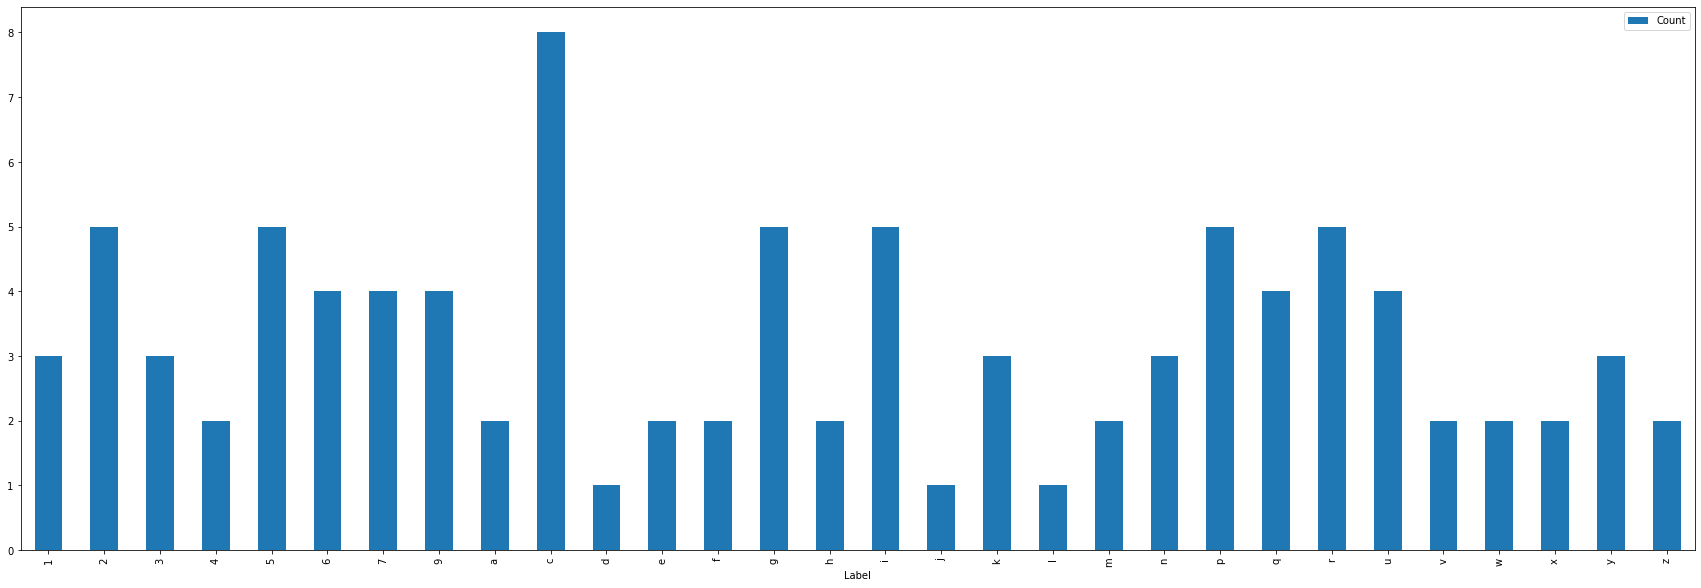

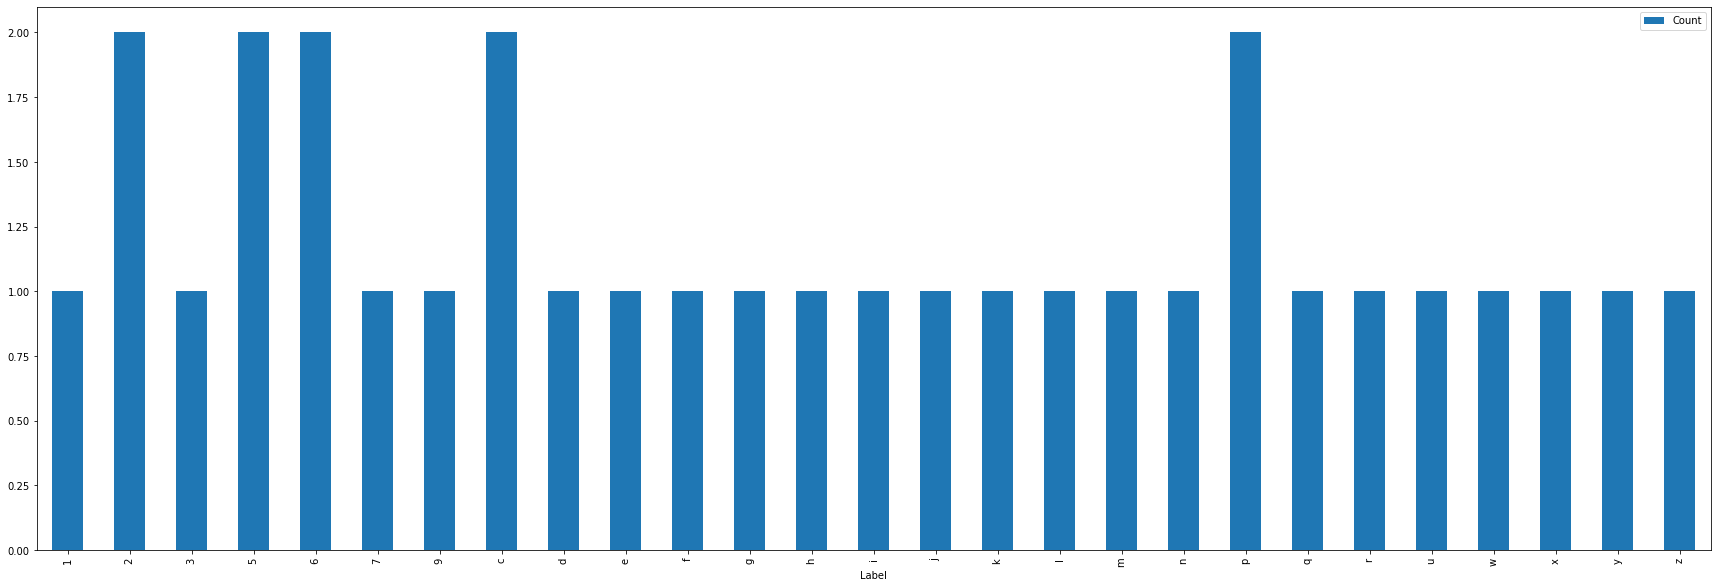

In [32]:
# Plot experiments
#df.groupby(["item", "color"])["id"].count().reset_index(name="count")
#df.groupby(['revenue','session','user_id'])['user_id'].count()
df_train_group.plot(x='Label',y='Count', kind='bar' , figsize = (30,10))
df_test_group.plot(x='Label',y='Count', kind='bar' , figsize = (30,10))




In [34]:
from keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(
       #rescale= 1. / 255.0,
       validation_split=0.10
)

test_datagenerator = ImageDataGenerator()#rescale= 1. / 255.0) 

In [35]:
train_images = train_datagenerator.flow_from_dataframe(
    dataframe=df_train,
    x_col='Filepath',
    y_col='Label',
    subset= "training",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)


val_images = train_datagenerator.flow_from_dataframe(
    dataframe=df_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset= "validation",
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0,
)



test_images = test_datagenerator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    class_mode='categorical',
    seed=0,
    batch_size=1,
    shuffle=False   
)

Found 86 validated image filenames belonging to 30 classes.
Found 9 validated image filenames belonging to 30 classes.
Found 31 validated image filenames belonging to 26 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [36]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.3), # Rotates the input images by a random value in the range[–30%, +30%] 
  layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
  ]
)

## Loading models

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from keras import backend as K
K.clear_session()


conv_base = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

conv_base.trainable = False

inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(33, activation="softmax")(x)
model = keras.Model(inputs,outputs)

In [ ]:
dir_name = PATH_HOME + "/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

path1 = os.path.join(dir_name,'weights_ft1')
path2 = os.path.join(dir_name,'weights_ft2')

model.summary()

conv_base.trainable = False

# method B
m = tf.keras.models.clone_model(model)
m.load_weights(path1)
extractor_1 = tf.keras.models.Model(inputs=m.inputs, outputs=m.get_layer('dense').output)
#extractor_1 = tf.keras.models.Model(inputs=m.inputs, outputs=m.get_layer('global_average_pooling2d').output)

# method C
m = tf.keras.models.clone_model(model)
m.load_weights(path2)
extractor_2 = tf.keras.models.Model(inputs=m.inputs, outputs=m.get_layer('dense').output)
#extractor_2 = tf.keras.models.Model(inputs=m.inputs, outputs=m.get_layer('global_average_pooling2d').output)


#Modello base
model_base = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling = "avg",
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#model_base.summary()



In [ ]:
path1 = os.path.join(dir_name,'model_ft_dense.h5')
extractor_1.save(path1)

In [ ]:
path1 = os.path.join(dir_name,'model_ft_dense.h5')
modelloProva = tf.keras.models.load_model(path1)

In [ ]:
extractor_1.summary()
modelloProva.summary()
extractor_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

## Generating features from models

In [ ]:
class Point:
  def __init__(self, features, img_id, label):
    self.features = features
    self.img_id = img_id
    self.label = label

   
def load_image_tf_base(path):
    image_pil = tf.keras.utils.load_img(path, target_size=input_shape,interpolation='bilinear')
    image_np = tf.keras.preprocessing.image.img_to_array(image_pil) 
    x = tf.keras.applications.inception_v3.preprocess_input(image_np)
    x = np.expand_dims(x, axis=0)
    x = np.expand_dims(image_np, axis=0)
    return x

def load_image_tf_fine_tuning(path):
    image_pil = tf.keras.utils.load_img(path, target_size=input_shape,interpolation='bilinear')
    image_np = tf.keras.preprocessing.image.img_to_array(image_pil) 
    #x = tf.keras.applications.inception_v3.preprocess_input(image_np)
    #x = np.expand_dims(x, axis=0)
    x = np.expand_dims(image_np, axis=0)
    return x

def get_featurePoints_from_images_base(paths,model,max):
  points_list = []
  i = 0
  for path in paths:
    label = str(path).split('/')[-2]
    if(label == "mirflickr"):
      label = "noise"
    img_id = str(path).split('/')[-1]
    np_img = load_image_tf_base(path)
    features = model.predict(np_img, verbose=0)
    points_list.append(Point(features, img_id, label))
    i = i + 1   
    print(i,"-Ho convertito immagine: ",img_id, "label: ", label)
    if(i == max):
      break
  return points_list


def get_featurePoints_from_images_fine_tuning(paths,model,max):
  points_list = []
  i = 0
  for path in paths:
    label = str(path).split('/')[-2]
    if(label == "mirflickr"):
      label = "noise"
    img_id = str(path).split('/')[-1]
    np_img = load_image_tf_fine_tuning(path)
    features = model.predict(np_img, verbose=0)
    points_list.append(Point(features, img_id, label))
    i = i + 1   
    print(i,"-Ho convertito immagine: ",img_id, "label: ", label)
    if(i == max):
      break
  return points_list

In [ ]:
#Questo codice potrebbe non essere eseguito alla prima: eseguirlo una seconda volta
dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
print(dir)
filepaths = list(dir.glob(r'*.jpg'))
print(len(filepaths))
noise_list = ["noise"] * len(filepaths)

print(noise_list)
print(len(noise_list))

df_mirflickr = build_pandas_dataframe(filepaths,noise_list)

print(df_mirflickr)

/content/drive/Shareddrives/MIRCV/dataset/mirflickr25k/mirflickr


KeyboardInterrupt: ignored

In [ ]:
#frames = [df_train[:400],df_test[:400],df_mirflickr[:400]]
frames = [df_train[:100],df_test[:20]]
total_dataframe = pd.concat(frames, ignore_index=True)
input_shape = (299,299,3)
print(total_dataframe)

print(len(total_dataframe))

                                              Filepath       Label
0    /content/drive/Shareddrives/MIRCV/dataset/prep...        corn
1    /content/drive/Shareddrives/MIRCV/dataset/prep...     raddish
2    /content/drive/Shareddrives/MIRCV/dataset/prep...  watermelon
3    /content/drive/Shareddrives/MIRCV/dataset/prep...       onion
4    /content/drive/Shareddrives/MIRCV/dataset/prep...    jalapeno
..                                                 ...         ...
115  /content/drive/Shareddrives/MIRCV/dataset/prep...  watermelon
116  /content/drive/Shareddrives/MIRCV/dataset/prep...       onion
117  /content/drive/Shareddrives/MIRCV/dataset/prep...    beetroot
118  /content/drive/Shareddrives/MIRCV/dataset/prep...       onion
119  /content/drive/Shareddrives/MIRCV/dataset/prep...      carrot

[120 rows x 2 columns]
120


In [ ]:
size = len(total_dataframe)
points_base = get_featurePoints_from_images_base(total_dataframe.Filepath,model_base,size)
points_ft1 = get_featurePoints_from_images_fine_tuning(total_dataframe.Filepath,extractor_1,size)
points_ft2 = get_featurePoints_from_images_fine_tuning(total_dataframe.Filepath,extractor_2,size)

1 -Ho convertito immagine:  img_56.jpg label:  corn
2 -Ho convertito immagine:  img_3407.jpg label:  raddish
3 -Ho convertito immagine:  img_147.jpg label:  watermelon
4 -Ho convertito immagine:  img_2271.png label:  onion
5 -Ho convertito immagine:  img_3610.jpg label:  jalapeno
6 -Ho convertito immagine:  img_239.jpg label:  pear
7 -Ho convertito immagine:  img_2002.jpg label:  turnip
8 -Ho convertito immagine:  img_1582.jpg label:  cauliflower
9 -Ho convertito immagine:  img_282.jpg label:  grapes
10 -Ho convertito immagine:  img_1554.jpg label:  cauliflower
11 -Ho convertito immagine:  img_102.jpg label:  turnip
12 -Ho convertito immagine:  img_2889.jpg label:  pear
13 -Ho convertito immagine:  img_2242.jpg label:  chilli_pepper
14 -Ho convertito immagine:  img_1708.jpg label:  beetroot
15 -Ho convertito immagine:  img_2907.png label:  pear
16 -Ho convertito immagine:  img_3443.jpg label:  raddish
17 -Ho convertito immagine:  img_872.jpg label:  garlic
18 -Ho convertito immagine:  

In [ ]:
#Salvataggio dei points di training, di testing e di mirflicker


## Codice VPTindex

In [ ]:
import random
import math
import time
from sklearn.metrics.pairwise import cosine_similarity

class Point:
  def __init__(self, features, img_id, label):
    self.features = features
    self.img_id = img_id
    self.label = label

class Node:
  def __init__(self):
    self.leaf = False
    self.left = None
    self.right = None
    self.median = None
    self.mean = None
    self.pivot = None

def distanceOfTwoPoints(point1,point2,metric=""):

  if metric.lower() == "eucledian":
    result = np.sqrt(np.sum(np.square(point1.features-point2.features)))
  elif metric.lower() == "manhattan":
    result = np.sum(abs(point1.features-point2.features))
  elif metric.lower() == "cosine":
    A = np.asarray(point1.features).reshape(1,-1)
    B = np.asarray(point2.features).reshape(1,-1)
    #Thanks to squeeze(), we return, for istance, 0.7849372 shape () instead of a [[0.7849372]] with (1,1) of shape
    result = 1 - cosine_similarity(A,B).squeeze()  
  else:
    print("ERRORE: Metrica non riconosciuta!")
    return 0
  return result

class Stack:
  # A list of (distance_i,class point_i)
  def __init__(self,k):
    self.size = k
    self.data = []
    self.index = 0
  
  def addElement(self,distance,point):

    if(self.isFull()):
      self.deleteLastElement()

    elem = (distance,point)
    self.data.append(elem)
    self.data.sort(key=lambda y: y[0])
    

      
  def deleteLastElement(self):
    if not self.isFull():
      print("Errore: Lista deve essere piena")
    else:
      del self.data[-1]
  
  #Pay attention in knn searching, dnn indicates the d_max of a stack
  # [(3,p4),(5,p2),(12,p5)]
  # d_max is equal to 12
  def update_d_max(self): #update dnn
    return self.data[-1][0]

  def isFull(self):
    return len(self.data) == self.size

class VPTree:

  def __init__(self, feature_schemas, bucket_size, distanceMetric):
    self.bucket_size = bucket_size
    self.feature_schemas = feature_schemas.copy()
    self.nodes = 0
    self.internalNodes = 0
    self.leafNodes = 0
    self.root = Node()
    self.totalFeatures = len(feature_schemas)
    self.distanceMetric = distanceMetric
    self.build(self.root, self.feature_schemas)


  def build(self, node, feature_subset):
    pivot = random.choice(feature_subset)
    feature_subset.remove(pivot) 

    #Nel calcolo delle distance devo escludere il vantage point
    distances = []

    #Compute distances in according to chosen pivot 
    for feature in feature_subset:   
      dist = distanceOfTwoPoints(feature,pivot,self.distanceMetric)
      distances.append(abs(dist))

    distances = np.array(distances)
    median = np.median(distances)

    subset1 = []
    subset2 = []

    #Split the remaining features in accoring to computed median
    for feature in feature_subset:
      dist = distanceOfTwoPoints(feature,pivot,self.distanceMetric)
      dist = abs(dist)
      if dist <= median:
        subset1.append(feature)
      else:
        subset2.append(feature)

    node.median = median
    node.pivot = pivot
    node.left = Node()
    node.right = Node()
    self.internalNodes += 1
    self.nodes += 1

    if len(subset1) <= self.bucket_size:
      node.left.subset = subset1
      node.left.leaf = True
      self.leafNodes += 1
      self.nodes += 1
    else:
      self.build(node.left, subset1)

    if len(subset2) <= self.bucket_size:
      node.right.subset = subset2
      node.right.leaf = True
      self.leafNodes += 1
      self.nodes += 1
    else:
      self.build(node.right, subset2)
  
  def range_search(self,query,range):
    self.feature_list = []
    self.recursive_range_search(self.root,query,range)
    return self.feature_list

  def recursive_range_search(self,node,query,range):
    if node.leaf == True:
      
      for point in node.subset:
        dist = distanceOfTwoPoints(query,point,self.distanceMetric)
        dist = abs(dist)
        if(dist <= range):
          tmp = []
          tmp.append(point)
          tmp.append(dist)
          self.feature_list.append(tmp)
      return
    
    #We insert the pivot if it is near to the query
    dist = distanceOfTwoPoints(query,node.pivot,self.distanceMetric)
    dist = abs(dist)
    if(dist <= range):
      tmp = []
      tmp.append(node.pivot)
      tmp.append(dist)
      self.feature_list.append(tmp)


    if(dist - range <= node.median):
      self.recursive_range_search(node.left, query, range)
    if(dist + range >= node.median):
      self.recursive_range_search(node.right, query, range)
    return

  def knn(self, query, k):
    #global time
    start_time = time.time()
    self.knn = Stack(k)
    self.d_max = math.inf
    self.visited = 0
    self.recursive_knn(self.root, query)
    results = []

    for elem in self.knn.data:
      results.append((elem[0],elem[1])) 

    self.timeknn = time.time() - start_time
    print("Time consumed: ", self.timeknn)
    print("Visited/Total elements: ",self.visited,"/",self.totalFeatures)

    return results
  
  def recursive_knn(self,node,query):
    if node.leaf == True:
      for point in node.subset:
        self.visited += 1
        #print("--foglia")
        #print("id node: ",point.img_id)
        #print("features node: ",point.features)
        distance = distanceOfTwoPoints(query,point,self.distanceMetric)
        #distance = query.features - point.features                    <------
        distance = abs(distance)
        #print("distance: ",distance)
        #print("actual dnn: ",self.d_max)
        #print("actual knn: ",self.knn.data)
        if not self.knn.isFull():
          self.knn.addElement(distance,point)
          self.d_max = self.knn.update_d_max()
        elif distance < self.d_max:
          self.knn.addElement(distance,point)
          #remove last element inside the stack
          self.d_max = self.knn.update_d_max()
        
        #print("new dnn: ",self.d_max)
        #print("new knn: ",self.knn.data)
        #print("-----------------------")
      return

    self.visited += 1
    #print("id node: ",node.pivot.img_id)
    #print("features node: ",node.pivot.features)
    #distance = query.features - node.pivot.features                  <-------
    distance = distanceOfTwoPoints(query,node.pivot,self.distanceMetric)
    distance = abs(distance)
    #print("distance: ",distance)
    #print("actual dnn: ",self.d_max)
    #print("actual knn: ",self.knn.data)

    if not self.knn.isFull():
      self.knn.addElement(distance,node.pivot)
      self.d_max = self.knn.update_d_max()
    elif distance < self.d_max:
      self.knn.addElement(distance,node.pivot)
      #remove last element inside the stack
      self.d_max = self.knn.update_d_max()
    #print("new dnn: ",self.d_max)
    #print("new knn: ",self.knn.data)

    if distance - self.d_max <= node.median:
      self.recursive_knn(node.left, query)
    if distance + self.d_max >= node.median:
      self.recursive_knn(node.right, query)
    return

  # function to print the tree, it will call print_tree
  def print_root(self):
      self.print_tree(self.root)

  def print_number_nodes(self):
    print("Total nodes: ", self.nodes)
    print(self.internalNodes," are Internal Nodes")
    print(self.leafNodes," are Leaf Nodes")
  # recursive function to print the tree
  def print_tree(self, node):
      if node.leaf == True:
          print("LEAF")
          print("Number of points in the node: ",len(node.subset))
          for elem in node.subset:
            print(elem.img_id)
            print(elem.features)
            print(elem.label)
          return
      else:
          print("INTERNAL")
          print("Pivot: ", node.pivot.img_id)
          print("Median: ", node.median)
          print("left")
          self.print_tree(node.left)
          print("right")
          self.print_tree(node.right)
          return

          


## Test 1
Test rapido per provare il comportamento della VPTree con le metriche *Euclidean* e *Manhattan*
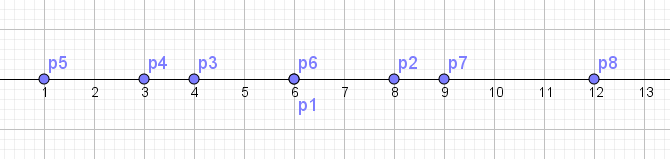

In [ ]:
#TEST 1
features = []

features.append(Point(6,"p1","prova"))
features.append(Point(8,"p2","prova"))
features.append(Point(4,"p3","prova"))
features.append(Point(3,"p4","prova"))
features.append(Point(1,"p5","prova"))
features.append(Point(6,"p6","prova"))
features.append(Point(9,"p7","prova"))
features.append(Point(12,"p8","prova"))




albero = VPTree(features,2,"Eucledian")
albero.print_number_nodes()
VPTree.print_root(albero)

In [ ]:
query = Point(5,"Pq","query")
lista = VPTree.range_search(albero,query,1)

for elem in lista:
  print("id: ", elem[0].img_id)
  print("features ", elem[0].features)
  print("distance from query: ", elem[1])

id:  p3
features  4
distance from query:  1.0
id:  p6
features  6
distance from query:  1.0
id:  p1
features  6
distance from query:  1.0


In [ ]:
query = Point(2,"Pq","query")
lista = VPTree.knn(albero,query,3)

for elem in lista:
  print("id_img: ",elem[1].img_id,"distance: ",elem[0])

## Test 2
Questo test è stato necessario per provare il comportamento della VPTree con la metrica *cosine_similarity*

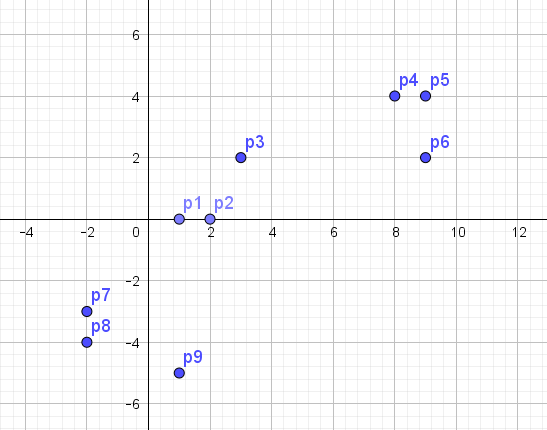

In [ ]:
#TEST 2
features = []

features.append(Point([1,0],"p1","prova"))
features.append(Point([2,0],"p2","prova"))
features.append(Point([3,2],"p3","prova"))
features.append(Point([8,4],"p4","prova"))
features.append(Point([9,4],"p5","prova"))
features.append(Point([9,2],"p6","prova"))
features.append(Point([-2,-3],"p7","prova"))
features.append(Point([-2,-4],"p8","prova"))
features.append(Point([1,-5],"p9","prova"))


albero = VPTree(features,2,"cosine")
albero.print_number_nodes()
VPTree.print_root(albero)

Total nodes:  9
4  are Internal Nodes
5  are Leaf Nodes
INTERNAL
Pivot:  p8
Median:  1.5389031102972117
left
INTERNAL
Pivot:  p9
Median:  0.803883864861816
left
INTERNAL
Pivot:  p2
Median:  0.7773500981126146
left
LEAF
Number of points in the node:  1
p1
[1, 0]
prova
right
LEAF
Number of points in the node:  1
p7
[-2, -3]
prova
right
LEAF
Number of points in the node:  0
right
INTERNAL
Pivot:  p4
Median:  0.007722123286332372
left
LEAF
Number of points in the node:  2
p3
[3, 2]
prova
p5
[9, 4]
prova
right
LEAF
Number of points in the node:  1
p6
[9, 2]
prova


In [ ]:
query = Point([1,0],"p1","prova")
results = VPTree.knn(albero,query,5)

for elem in results:
  print(elem[1].img_id)

Time consumed:  0.005506753921508789
Visited/Total elements:  9 / 9
p2
p1
p6
p5
p4


In [ ]:
query = Point([2,0],"p2","prova")
results = VPTree.knn(albero,query,5)

for elem in results:
  print(elem[1].img_id)

Time consumed:  0.00561833381652832
Visited/Total elements:  9 / 9
p2
p1
p6
p5
p4


## Test by using features from models

### Selection query image

In [ ]:
#113 -Ho convertito immagine:  img_1423.jpg label:  lettuce
query_id = 112
query = points_base[query_id] 
query1 = points_ft1[query_id]
query2 = points_ft2[query_id]

print(query.label)
print(query.img_id)
print(query1.label)
print(query1.img_id)
print(query2.label)
print(query2.img_id)

lettuce
img_1423.jpg
lettuce
img_1423.jpg
lettuce
img_1423.jpg


### Building VantagePointTree

In [ ]:
albero_base = VPTree(points_base,10,"cosine")
albero_ft1 = VPTree(points_ft1,10,"cosine")
albero_ft2 = VPTree(points_ft2,10,"cosine")

### KNN Search

In [ ]:
k = 10
results = VPTree.knn(albero_base,query,k)
results1 = VPTree.knn(albero_ft1,query1,k)
results2 = VPTree.knn(albero_ft2,query2,k)

Time consumed:  0.06673312187194824
Visited/Total elements:  120 / 120
Time consumed:  0.06250548362731934
Visited/Total elements:  114 / 120
Time consumed:  0.06010913848876953
Visited/Total elements:  120 / 120


In [ ]:
dir = Path(PATH_DATASET)
input_shape = (299,299,3)


print("--------------------features_base--------------------")
num=1
for elem in results:
  print("n:--- ",num,"label: ", elem[1].label, "scores: ", elem[0])
  if elem[1].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[1].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[1].label,elem[1].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num=1
print("--------------------features_ft1--------------------")
for elem in results1:
  print("n:--- ",num,"label: ", elem[1].label, "scores: ", elem[0])
  if elem[1].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[1].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[1].label,elem[1].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num = 1
print("--------------------features_ft2--------------------")
for elem in results2:
  print("n:--- ",num,"label: ", elem[1].label, "scores: ", elem[0])
  #--------------------------------
  if elem[1].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[1].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[1].label,elem[1].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num=1

Output hidden; open in https://colab.research.google.com to view.

###Range Search

In [ ]:
results = VPTree.range_search(albero_base,query,0.50)
results1 = VPTree.range_search(albero_ft1,query1,11)
results2 = VPTree.range_search(albero_ft2,query2,11)


print(results)
#elem = (distance,point)
#self.data.append(elem)
results.sort(key=lambda y: y[1])
#results1.sort(key=lambda y: y[1])
#results2.sort(key=lambda y: y[1])

#[(point1,score),(point2,score)....] range
#[(score,point1),(score,point2)...] knn

dir = Path(PATH_DATASET)
input_shape = (299,299,3)


print("--------------------features_base--------------------")
num=1
for elem in results:
  print("n:--- ",num,"label: ", elem[0].label, "scores: ", elem[1])
  if elem[0].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[0].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[0].label,elem[0].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num=1
print("--------------------features_ft1--------------------")
for elem in results1:
  print("n:--- ",num,"label: ", elem[0].label, "scores: ", elem[1])
  if elem[0].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[0].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[0].label,elem[0].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num = 1
print("--------------------features_ft2--------------------")
for elem in results2:
  print("n:--- ",num,"label: ", elem[0].label, "scores: ", elem[1])
  if elem[0].label == "noise" :
    dir = Path(PATH_HOME +'dataset/mirflickr25k/mirflickr/')
    img_path = os.path.join(dir,elem[0].img_id)
  else:
    dir = Path(PATH_DATASET)
    img_path = os.path.join(dir,elem[0].label,elem[0].img_id)
  #---------------------------------------
  image_pil = tf.keras.utils.load_img(img_path, target_size=input_shape)
  display(image_pil)
  num = num + 1
num=1